# Generation and Calibration (3compartment -> no_arm_CVS)

This notebook walks through the end-to-end workflow for generating, simulating, and calibrating a 3compartment model, then extending to a 0D-1D hybrid.

## Steps overview
1. Set up imports and paths.
2. Open vessel array file for 3compartment (switch to no_arm_CVS) in PhLynx.
3. Generate CellML model from PhLynx (saved to Downloads).
4. Load the model with `SimulationHelper`.
5. Plot ground-truth data vs. uncalibrated outputs.
6. Add arm vessels in PhLynx and regenerate.
7. Set the observable data for calibration.
8. Create `params_for_id.csv` from Python.
9. Run sensitivity analysis over a large parameter set.
10. View sensitivity analysis plots.
11. Add an extra feature to fit to.
12. Choose the most influential parameters (e.g., top 2).
13. Run parameter identification (genetic algorithm).
14. Review calibration outputs.
15. Calculate PWV with the 0D model.
16. Switch selected vessels to 1D and generate C++ model.
17. Run the C++ model.
18. Load and plot 0D-1D hybrid results.
19. Compare PWV for 0D vs 0D-1D.
20. Concise-call hints (commented).

> Update paths and filenames to match your environment.


![optional caption](diagram_cvs_model_without_left_arm.png)

## 1) Set up imports and paths

In [1]:
%load_ext autoreload
%autoreload 2

# Core imports
from pathlib import Path
import os
import sys

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')
import matplotlib.pyplot as plt
try:
    import opencor as oc
except:
    print('opencor not available, open this jupyter notebook with a python version that has opencor installed')
    exit()

print("Imports done")

# Ensure local src is importable
project_root = Path("/home/farg967/Documents/git_projects/circulatory_autogen")
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# Set up paths
resources_dir = project_root / "resources" # TODO: change to the downloads dir if using Phlynx output directly
generated_models_dir = project_root / "generated_models"
param_id_output_dir = project_root / "param_id_output"
this_dir = project_root / "tutorial" / "interactive"
downloads_dir = Path.home() / "Downloads"

print("Paths done")

Imports done
Paths done


/home/farg967/software/OpenCOR-0-8-3-Linux/Python/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/farg967/software/OpenCOR-0-8-3-Linux/Python/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## 2) Open vessel array in PhLynx (manual)

- Open the 3compartment  vessel array in PhLynx [LINK_TO_PHLYNX].
- Save/export the vessel array so it is ready for CellML generation. [TO_REPLACE_WITH_GENERATED_CELLML_MODEL]

## 3) Generate CellML in PhLynx (manual)

- In PhLynx, generate the CellML model for the edited vessel array.
- The exported file is typically saved to `~/Downloads`.
- Note the exported filename (e.g., `3compartment.cellml`). 

In [2]:
from utilities.utility_funcs import get_default_inp_data_dict
import pprint
# Model identifiers
model_name = "cvs_model"
# file_prefix = "3compartment" 
file_prefix = model_name+"_0d" 
input_param_file = f"{file_prefix}_parameters.csv"

# Base user inputs (this shows all the settings that can be changed)
inp_data_dict = get_default_inp_data_dict(file_prefix, input_param_file, resources_dir)

print('inp_data_dict set')
pprint.pprint(inp_data_dict)


inp_data_dict set
{'DEBUG': False,
 'couple_to_1d': False,
 'do_ia': False,
 'dt': 0.01,
 'external_modules_dir': None,
 'file_prefix': 'cvs_model_0d',
 'generated_models_dir': '/home/farg967/Documents/git_projects/circulatory_autogen/src/parsers/../../generated_models',
 'generated_models_subdir': '/home/farg967/Documents/git_projects/circulatory_autogen/src/parsers/../../generated_models/cvs_model_0d',
 'ia_options': {'method': 'Laplace'},
 'input_param_file': 'cvs_model_0d_parameters.csv',
 'model_path': '/home/farg967/Documents/git_projects/circulatory_autogen/src/parsers/../../generated_models/cvs_model_0d/cvs_model_0d.cellml',
 'model_type': 'cellml_only',
 'optimiser_options': {},
 'param_id_output_dir': '/home/farg967/Documents/git_projects/circulatory_autogen/src/parsers/../../param_id_output',
 'parameters_csv_abs_path': '/home/farg967/Documents/git_projects/circulatory_autogen/resources/cvs_model_0d_parameters.csv',
 'pre_time': None,
 'resources_dir': '/home/farg967/Documen

In [3]:
from scripts.script_generate_with_new_architecture import generate_with_new_architecture
import shutil

# Generate directly from resources CSVs
success = generate_with_new_architecture(inp_data_dict=inp_data_dict)
if not success:
    raise RuntimeError("Model generation failed")
else:
    print('Model generation successful')



/home/farg967/software/OpenCOR-0-8-3-Linux/Python/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/farg967/software/OpenCOR-0-8-3-Linux/Python/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Check point 0


Generating model files at /home/farg967/Documents/git_projects/circulatory_autogen/src/parsers/../../generated_models/cvs_model_0d
Generating CellML file cvs_model_0d_units.cellml
Generating CellML file cvs_model_0d.cellml
writing units mapping
writing imports
writing vessel mappings
writing environment to sum venous input flows
writing environment to sum generic junctions input flows
writing environment to apply operations for multiports
writing variable access
writing global params variable access
writing mappings between computational environment and modules
writing mappings between computational environment and modules for global parameters
writing mappings between constant params
writing writing time mappings between environment and modules
Generating CellML file cvs_model_0d_parameters.cellml
Generating modules file cvs_model_0d_modules.cellml
Model generation complete.
Checking Status of Model
The method "parse_model" found 79 issues:
    - Given model is a CellM

## 4) Load the model with SimulationHelper

Use the solver wrapper to load the CellML model and prepare a simulation helper.

dt_solver is not a valid key for CVODE solver properties; valid keys are ['AbsoluteTolerance', 'IntegrationMethod', 'InterpolateSolution', 'IterationType', 'LinearSolver', 'LowerHalfBandwidth', 'MaximumNumberOfSteps', 'MaximumStep', 'Preconditioner', 'RelativeTolerance', 'UpperHalfBandwidth']. Skipping.


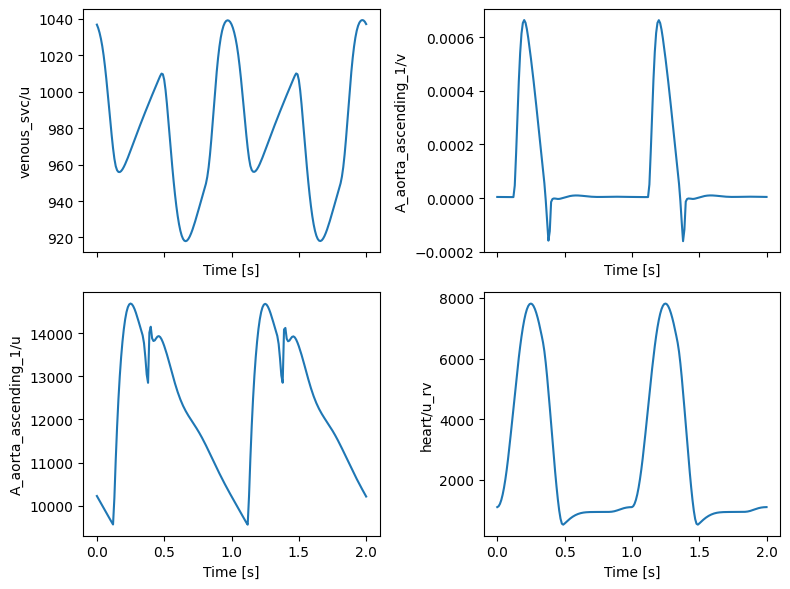

In [4]:
from solver_wrappers import get_simulation_helper_from_inp_data_dict

# Simulation settings
inp_data_dict["sim_time"] = 2 # the 2 seconds we care about
inp_data_dict["pre_time"] = 20.0 # simulate for 20 seconds to get to periodic steady state

sim_helper = get_simulation_helper_from_inp_data_dict(inp_data_dict)

# Run once and plot a few representative variables
sim_helper.run()
variables_to_plot = [
    "venous_svc/u",
    "A_aorta_ascending_1/v",
    "A_aorta_ascending_1/u",
    "heart/u_rv",
]

y = sim_helper.get_results(variables_to_plot, flatten=True)
t = sim_helper.get_time()

##### Plotting #####

plot_dir = Path(param_id_output_dir) / "quicklooks"
plot_dir.mkdir(parents=True, exist_ok=True)

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(8, 6))
axs = axs.flatten()
for idx, (ax, series, name) in enumerate(zip(axs, y, variables_to_plot)):
    ax.plot(t, series)
    ax.set_ylabel(name)
    ax.set_xlabel("Time [s]")

plt.tight_layout()
plt.savefig(plot_dir / "uncalibrated_outputs.png")
plt.show()

## 5) Plot ground-truth data vs uncalibrated outputs

Load the ground-truth data and compare it to the uncalibrated simulation results.

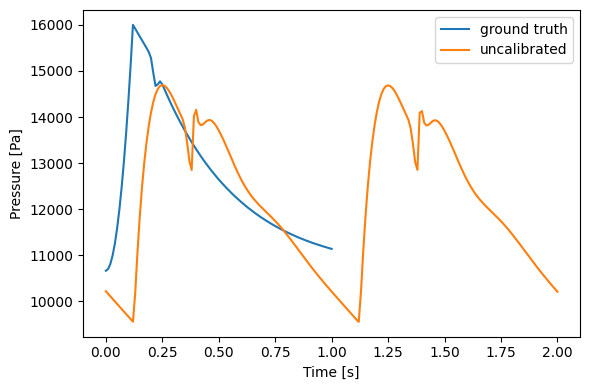

In [5]:
# TODO: update with your ground-truth data file
# Example assumes a CSV with a time column and measurement columns

ground_truth_file = os.path.join(this_dir, "resources", "aorta_pressure_temp.txt")
if os.path.exists(ground_truth_file):
    gt = pd.read_csv(ground_truth_file, sep="\t")

    time_col = "time_s"
    var_col = "pressure_mmHg"

    time_gt = gt[time_col].to_numpy()
    pressure_pa = gt[var_col].to_numpy() * 133.322  # mmHg -> Pa

    plt.figure(figsize=(6, 4))
    plt.plot(time_gt, pressure_pa, label="ground truth")
    plt.plot(t, y[2], label="uncalibrated")
    plt.xlabel("Time [s]")
    plt.ylabel("Pressure [Pa]")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Ground-truth file not found: {ground_truth_file}")

## 6) Add arm vessels in PhLynx (manual)

- Add arm vessels in PhLynx.
- Regenerate the CellML model.
- If you exported a new CellML file, re-run the copy/generation cell above.

# 6) Create a parameter identification object which will be used to set up your calibration problem

In [8]:
from param_id.paramID import CVS0DParamID

# first create a a param id object which will be used to set up out calibration problem
solver_info = {
    "dt": 0.01,
    "pre_time": 20.0,
    "sim_time": 2.0,
    "solver_type": "cvode",
    "solver_options": {"atol": 1e-6, "rtol": 1e-6},
}
# TOSO SOLVER INFO NOT USED

param_id = CVS0DParamID(
    model_path=inp_data_dict["model_path"],
    model_type="cellml_only",
    param_id_method="genetic_algorithm",
    file_name_prefix=file_prefix # name here only needed for saved files
)

# you could also have called the below to use the inp_data_dict created previously
# TODO probably change to the below
# param_id = CVS0DParamID.init_from_dict(inp_data_dict)


No optimiser options provided, using default options
Default optimiser options: {'cost_convergence': 0.0001, 'max_patience': 10, 'num_calls_to_function': 10000}


## 7) Set the observable data that you want to calibrate towards

In [9]:
from utilities.obs_data_helpers import ObsDataCreator

# now create the obs data creator object for creating a dictionary that contains the data you will fit towards
obs_data_creator = ObsDataCreator()

# Protocol info (this defines your times and changes of inputs in the experiment)
pre_times = [[20]]
sim_times = [[time_gt[-1]]]
obs_dt = time_gt[1]-time_gt[0]
params_to_change = {}
obs_data_creator.add_protocol_info(pre_times, sim_times, params_to_change)

# Currently we fit to features from the trace, you can change this to fit to the series itself
# TODO make sure Mohammad's code is working for the SA for this.

fit_to_series = False

if fit_to_series: 
    # Data items (fill with your actual observation series)
    # Example placeholder (replace with real data)
    # input entries into add_data_item
    entry = {
        "variable": "P aortic root",
        "name_for_plotting": "$P_{ao}$",
        "operation": None, # tells what operation to do on the operands to compare to value
        "operands": ["A_aorta_ascending_1/u"],
        "unit": "Pa", 
        "weight": 1.0, # allows you to weight the data item differently
        "value": pressure_pa,
        "std": pressure_pa*0.1, # assume 10% Coefficient of variation for now
        "obs_dt": obs_dt,  
    }
    obs_data_creator.add_data_item(entry)

else:
    # add an entry for just fitting the mean of the pressure
    entry = {
        "variable": "P aortic root mean",
        "name_for_plotting": "$P_{aoMean}$",
        "operands": ["A_aorta_ascending_1/u"],
        "operation": "mean",
        "unit": "Pa",
        "value": np.mean(pressure_pa),
        "std": 200, # assumed std of the mean pressure
        "obs_dt": obs_dt,
    }
    obs_data_creator.add_data_item(entry)
    

obs_data_dict = obs_data_creator.get_obs_data_dict()

# pprint.pprint(obs_data_dict)

# now add the obs to the param id object
param_id.set_ground_truth_data(obs_data_dict)


Setting ground truth data: {'protocol_info': {'pre_times': [[20]], 'sim_times': [[1.0]], 'params_to_change': {}, 'experiment_labels': ['exp_0']}, 'prediction_items': [], 'data_items': [{'variable': 'P aortic root mean', 'name_for_plotting': '$P_{aoMean}$', 'operands': ['A_aorta_ascending_1/u'], 'operation': 'mean', 'unit': 'Pa', 'value': 12718.786798019806, 'std': 200, 'obs_dt': 0.01, 'weight': 1.0, 'subexperiment_idx': 0, 'experiment_idx': 0, 'data_type': 'constant'}]}
constant data types plot type defaults to horizontal lines change "plot_type" in obs_data.json to change this
Ground truth data set: {'obs_names': ['P aortic root mean'], 'data_types': ['constant'], 'units': ['Pa'], 'experiment_idxs': [0], 'subexperiment_idxs': [0], 'plot_colors': ['b'], 'plot_type': ['horizontal'], 'operations': ['mean'], 'operands': [['A_aorta_ascending_1/u']], 'operation_kwargs': [{}], 'freqs': [None], 'names_for_plotting': ['$P_{aoMean}$'], 'num_obs': 1, 'weight_const_vec': array([1.]), 'weight_seri

## 8) Create params_for_id.csv from Python

Define the parameter bounds for identification in a CSV file. Use the same schema as `resources/3compartment_params_for_id.csv`.


In [10]:
# TODO: replace with your full parameter set

params_for_id_dict = [
    {
        "vessel_name": "global",
        "param_name": "q_lv_init",
        "min": 400e-6,
        "max": 2500e-6,
        "name_for_plotting": "q_{sbv}",
    },
    {
        "vessel_name": "K_tube_A_aorta_ascending_1",
        "param_name": "E",
        "min": 8e+4,
        "max": 4e+5,
        "name_for_plotting": "E_{ao}",
    }
]

print(params_for_id_dict)
# TODO the below might be easier to understand
# param_id.add_param_for_id(module_name, param_name, min, max, name_for_plotting)
# param_id.add_param_for_id(module_name, param_name, min, max, name_for_plotting)


# now add the params to the param id object
param_id.set_params_for_id(params_for_id_dict)


[{'vessel_name': 'global', 'param_name': 'q_lv_init', 'min': 0.0004, 'max': 0.0025, 'name_for_plotting': 'q_{sbv}'}, {'vessel_name': 'K_tube_A_aorta_ascending_1', 'param_name': 'E', 'min': 80000.0, 'max': 400000.0, 'name_for_plotting': 'E_{ao}'}]
Setting params for id: [{'vessel_name': 'global', 'param_name': 'q_lv_init', 'min': 0.0004, 'max': 0.0025, 'name_for_plotting': 'q_{sbv}'}, {'vessel_name': 'K_tube_A_aorta_ascending_1', 'param_name': 'E', 'min': 80000.0, 'max': 400000.0, 'name_for_plotting': 'E_{ao}'}]
Params for id set: [['global/q_lv_init'], ['K_tube_A_aorta_ascending_1/E']]


## 9) Sensitivity analysis

Run Sobol sensitivity analysis over a large parameter set and save outputs to a defined directory.


In [11]:
from sensitivity_analysis.sensitivityAnalysis import SensitivityAnalysis
import shutil

sa_output_dir = Path(param_id_output_dir) / "sensitivity" / file_prefix
if sa_output_dir.exists():
    shutil.rmtree(sa_output_dir) # remove the directory if it exists
sa_output_dir.mkdir(parents=True, exist_ok=True)


sa_options = {
    "method": "sobol",
    "sample_type": "saltelli",
    "num_samples": 16, # change to 256
    "output_dir": str(sa_output_dir),
}

sa_agent = SensitivityAnalysis.init_from_dict(inp_data_dict)



sa_agent.set_ground_truth_data(obs_data_dict)
sa_agent.set_params_for_id(params_for_id_dict)
sa_agent.set_sa_options(sa_options)

sa_agent.run_sensitivity_analysis(sa_options)
sa_output_dir


dt_solver is not a valid key for CVODE solver properties; valid keys are ['AbsoluteTolerance', 'IntegrationMethod', 'InterpolateSolution', 'IterationType', 'LinearSolver', 'LowerHalfBandwidth', 'MaximumNumberOfSteps', 'MaximumStep', 'Preconditioner', 'RelativeTolerance', 'UpperHalfBandwidth']. Skipping.
Setting ground truth data: {'protocol_info': {'pre_times': [[20]], 'sim_times': [[1.0]], 'params_to_change': {}, 'experiment_labels': ['exp_0'], 'num_experiments': 1, 'num_sub_per_exp': [1], 'num_sub_total': 1, 'total_sim_times_per_exp': [1.0], 'tSims_per_exp': [array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 

Rank 0: 100%|█████████████████████████████████████████| 96/96 [01:31<00:00,  1.05it/s]


[MPI Rank 0] Finished processing samples 0:96
[MPI Rank 0] Gathered and flattened all outputs. Total outputs: (96, 1)
Sensitivity analysis completed successfully :)
saving results in /home/farg967/Documents/git_projects/circulatory_autogen/param_id_output/sensitivity/cvs_model_0d

Generating Sobol Index Heatmaps...
Saved First-Order ($S_1$) heatmap to /home/farg967/Documents/git_projects/circulatory_autogen/param_id_output/sensitivity/cvs_model_0d/First_Order ($S_1$)_Sobol_Heatmap.png
Saved Total-Order ($S_T$) heatmap to /home/farg967/Documents/git_projects/circulatory_autogen/param_id_output/sensitivity/cvs_model_0d/Total_Order ($S_T$)_Sobol_Heatmap.png


PosixPath('/home/farg967/Documents/git_projects/circulatory_autogen/param_id_output/sensitivity/cvs_model_0d')

## 10) View the sensitivity analysis plots

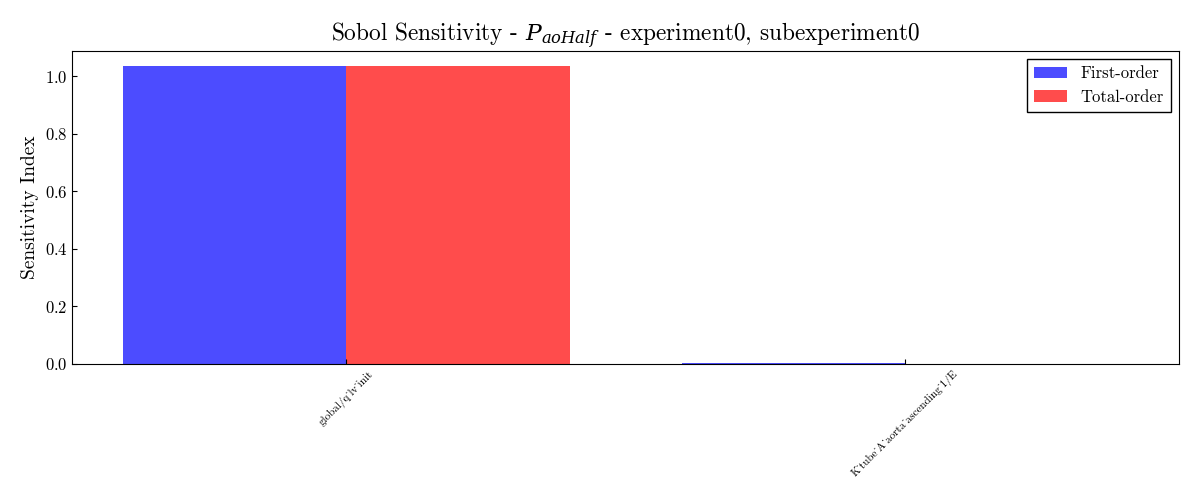

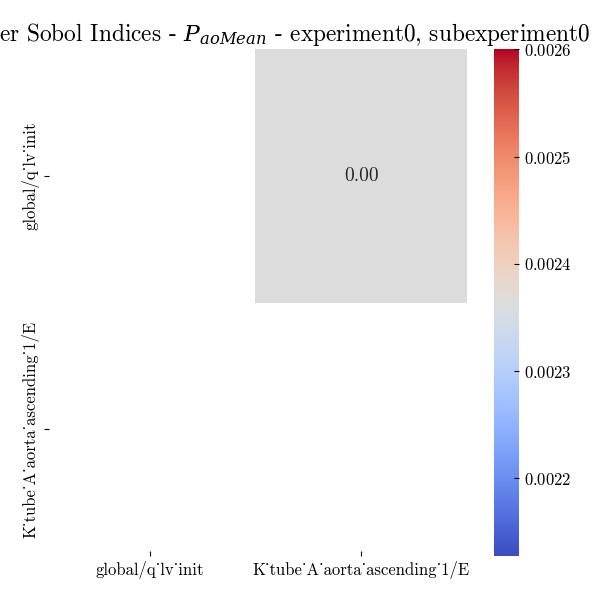

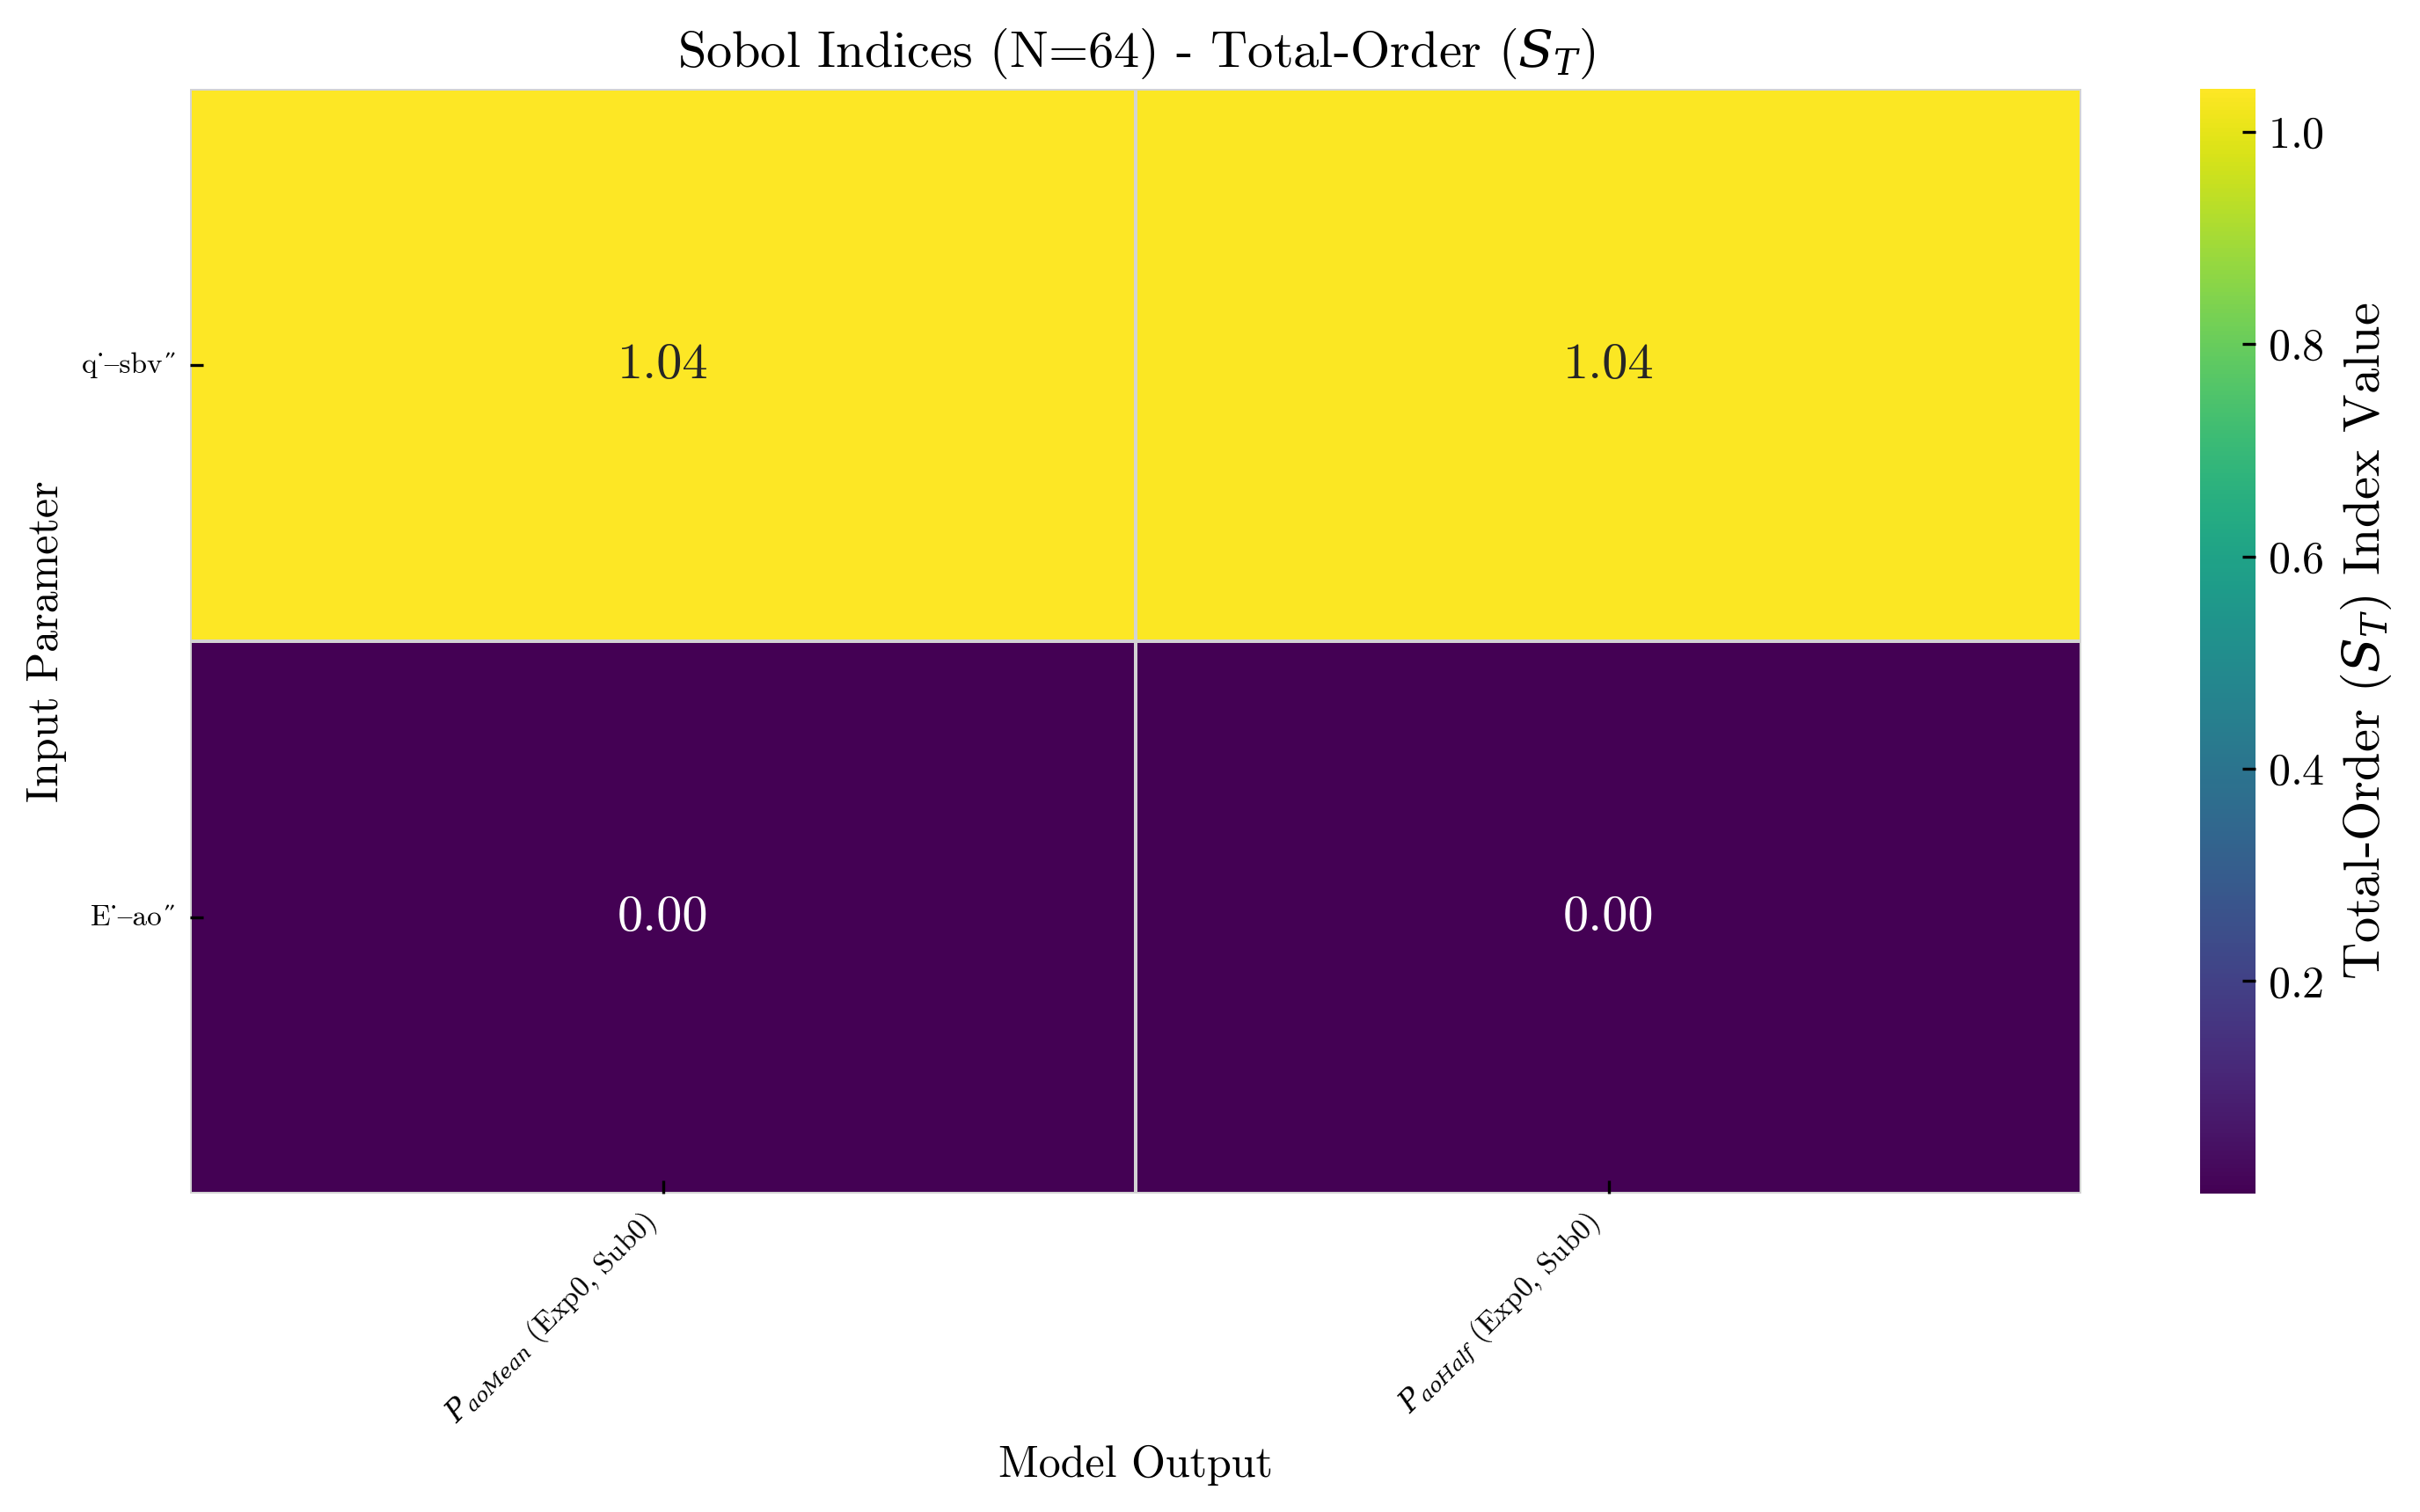

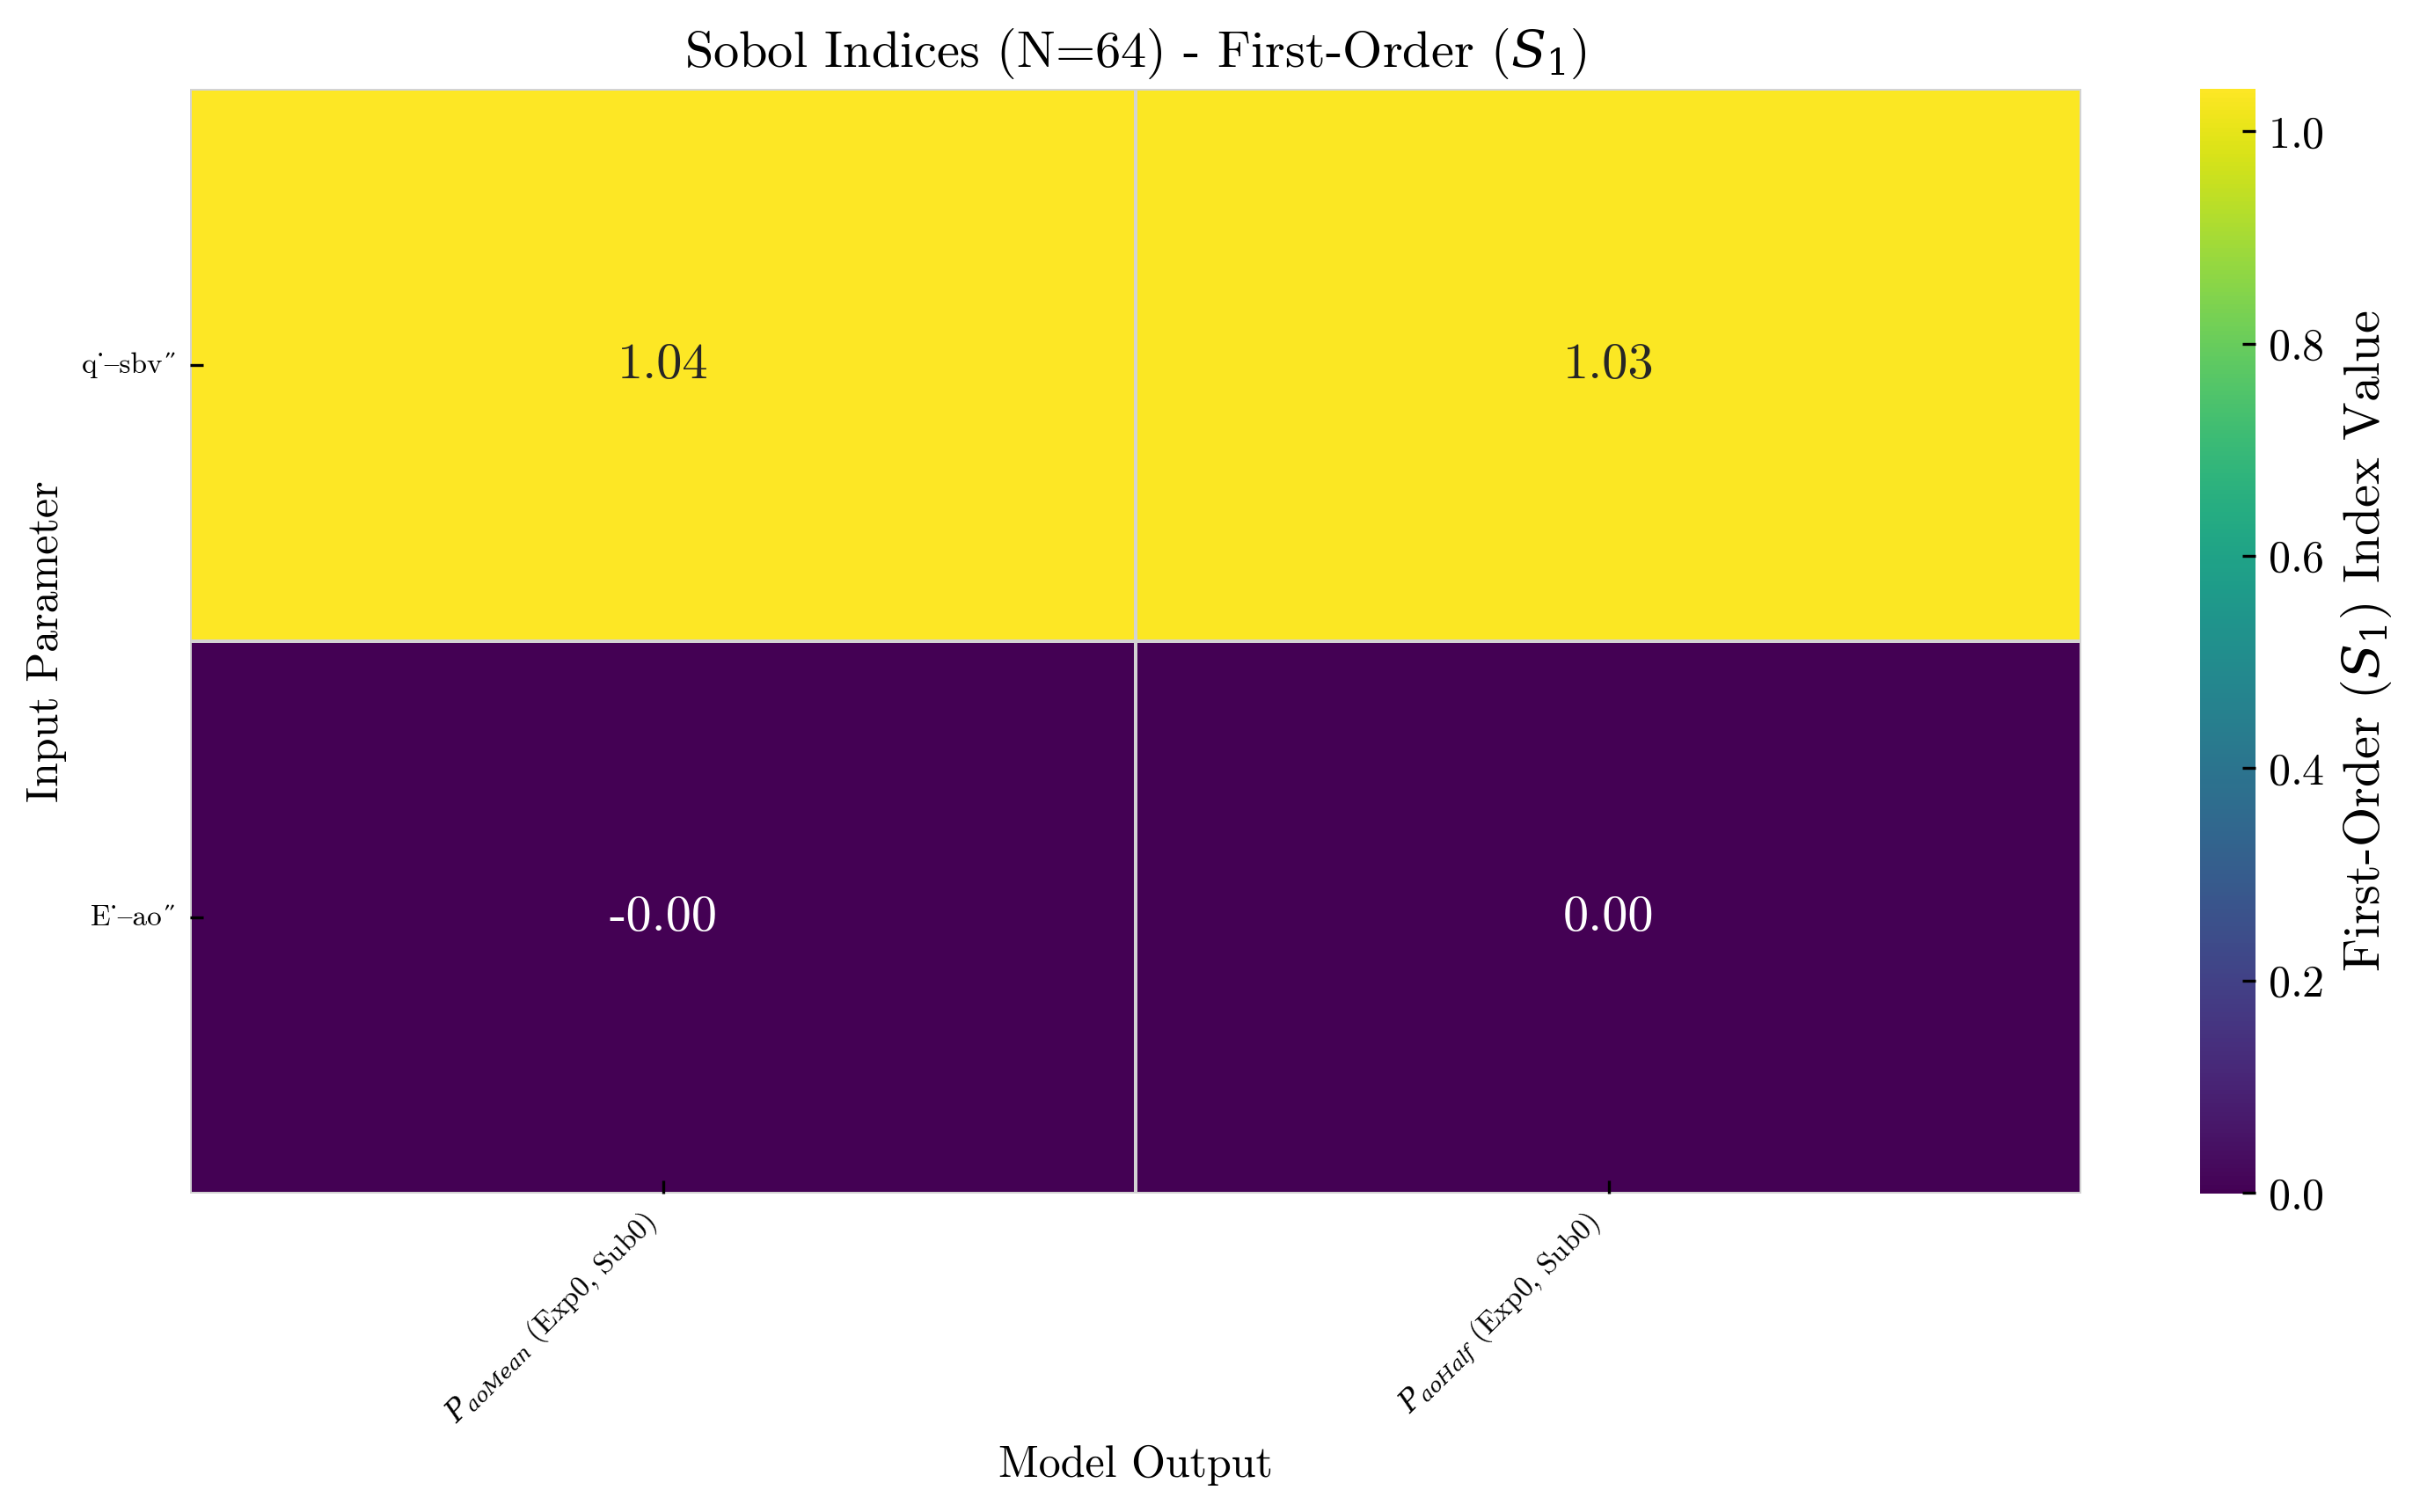

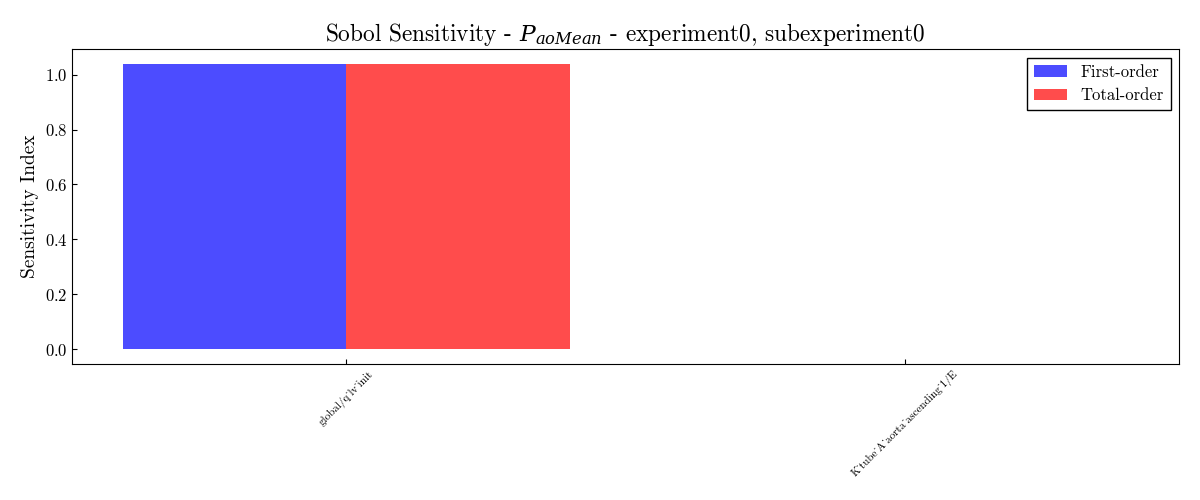

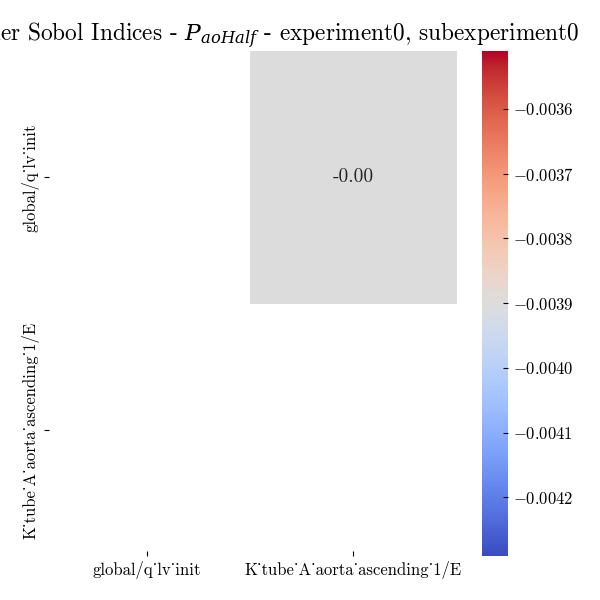

In [14]:
from IPython.display import Image, display

# Display the plots from the sensitivity analysis
plot_files = [file_path for file_path in sa_output_dir.glob("*.png")]
for plot_file in plot_files:
    display(Image(filename=str(plot_file)))


## 11) Now add your own extra feature to fit to.


In [12]:

# =====  this is an example of how to add a custom feature to the obs data creator =====
# this feature calculates the pressure at one point in time. 
# Modify this function to extract whatever feature you want! Max? Min? weights of a certain basis? Anything you want.

# Create your own feature to fit to
def my_extra_feature(time, pressure):
    half_idx = len(time) // 2
    return pressure[half_idx]

sa_agent.add_user_operation_func(my_extra_feature)
param_id.add_user_operation_func(my_extra_feature)

extra_entry = {
    "variable": "P aortic root half time",
    "name_for_plotting": "$P_{aoHalf}$",
    "operands": ["time","A_aorta_ascending_1/u"], # these need to correspond to the operands in my_extra_feature
    "operation": "my_extra_feature",
    "unit": "Pa",
    "value": my_extra_feature(time_gt, pressure_pa), # this uses your function to get the value you want to fit to from the ground truth data
    "std": 200, # assumed std of the pressure
}

obs_data_creator.add_data_item(extra_entry)
obs_data_dict = obs_data_creator.get_obs_data_dict()

In [13]:

sa_agent.set_ground_truth_data(obs_data_dict)

# remove the old results before running.
if sa_output_dir.exists():
    shutil.rmtree(sa_output_dir) # remove the directory if it exists
sa_output_dir.mkdir(parents=True, exist_ok=True)

sa_agent.run_sensitivity_analysis(sa_options)

# Display the plots from the sensitivity analysis
plot_files = [file_path for file_path in sa_output_dir.glob("*.png")]
for plot_file in plot_files:
    display(Image(filename=str(plot_file)))


Setting ground truth data: {'protocol_info': {'pre_times': [[20]], 'sim_times': [[1.0]], 'params_to_change': {}, 'experiment_labels': ['exp_0'], 'num_experiments': 1, 'num_sub_per_exp': [1], 'num_sub_total': 1, 'total_sim_times_per_exp': [1.0], 'tSims_per_exp': [array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])], 'num_steps_total_per_exp': [100], 'experiment_colors': ['r

Rank 0: 100%|█████████████████████████████████████████| 96/96 [01:34<00:00,  1.02it/s]


[MPI Rank 0] Finished processing samples 0:96
[MPI Rank 0] Gathered and flattened all outputs. Total outputs: (96, 2)
Sensitivity analysis completed successfully :)
saving results in /home/farg967/Documents/git_projects/circulatory_autogen/param_id_output/sensitivity/cvs_model_0d

Generating Sobol Index Heatmaps...
Saved First-Order ($S_1$) heatmap to /home/farg967/Documents/git_projects/circulatory_autogen/param_id_output/sensitivity/cvs_model_0d/First_Order ($S_1$)_Sobol_Heatmap.png
Saved Total-Order ($S_T$) heatmap to /home/farg967/Documents/git_projects/circulatory_autogen/param_id_output/sensitivity/cvs_model_0d/Total_Order ($S_T$)_Sobol_Heatmap.png


NameError: name 'Image' is not defined

## 12) Choose influential parameters

Review the sensitivity analysis outputs (plots/arrays) to choose the most influential parameters (e.g., top 2).


In [ ]:
# TODO: inspect SA outputs in sa_output_dir and pick top parameters
# Example placeholder list:
most_influential_params = [
    "global/q_lv_init"
]
most_influential_params


['global/q_lv_init', 'aortic_root/C']

## 13) Parameter identification (genetic algorithm)

Use the genetic algorithm to calibrate model parameters.

$$
\theta^{\star} = \arg\min_{\theta \in \Theta} \; \sum_{i=1}^{N} w_i \left\lVert \frac{z_i(\theta) - \hat{z_i}}{\sigma_i} \right\rVert^2
$$

where $\theta^{\star}$ is the best fit parameter vector, $\Theta$ is your parameter space, defined by the min and max you set in params_for_id_dict, $z_i$ are your output features, $\hat{z_i}$ are your ground truths for those features, $\sigma_i$ are your feature standard deviations, and $w_i$ are the weights for each feature.


In [ ]:
from param_id.paramID import CVS0DParamID

inp_data_dict["param_id_method"] = "genetic_algorithm"
param_id.set_param_id_method(inp_data_dict["param_id_method"])

# Optimiser options (adjust as needed)
optimiser_options = {
    "num_calls_to_function": 1000,
    "cost_convergence": 0.001,
    "max_patience": 10,
    "cost_type": "MSE",
}

param_id.set_optimiser_options(optimiser_options)
param_id.set_ground_truth_data(obs_data_dict)

# update params for id dict with most influential params

param_id.set_params_for_id(params_for_id_dict)

# TODO I am up to here for debugging
# TODO protocol info isn't getting created correctly.

# Run calibration
param_id.run()

# Plot best fit
param_id.simulate_with_best_param_vals()
param_id.plot_outputs()


Setting ground truth data: {'protocol_info': {'pre_times': [[20]], 'sim_times': [[1.0]], 'params_to_change': {}, 'experiment_labels': ['exp_0'], 'num_experiments': 1, 'num_sub_per_exp': [1], 'num_sub_total': 1, 'total_sim_times_per_exp': [1.0], 'tSims_per_exp': [array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])], 'num_steps_total_per_exp': [100], 'experiment_colors': ['r

/home/farg967/Documents/git_projects/circulatory_autogen/src/param_id/paramID.py:2238: SyntaxWarning: invalid escape sequence '\.'
  self.param_id_obs_file_prefix = re.sub('\.json', '', os.path.split(param_id_obs_path)[1])


TypeError: 'NoneType' object is not subscriptable

## 14) Review calibration outputs

The calibration process saves plots and arrays in the parameter ID output directory. Use this section to view the plots. You can also make your own plots with the saved outputs


In [ ]:
output_dir = Path(param_id.output_dir)
print("Outputs saved to:", output_dir)

# Example: load best parameters
best_params_path = output_dir / "best_param_vals.npy"
if best_params_path.exists():
    best_params = np.load(best_params_path)
    best_params
else:
    print("best_param_vals.npy not found")

# Display the plots from the param id
plot_files = [file_path for file_path in output_dir.glob("*.png")]
for plot_file in plot_files:
    display(Image(filename=str(plot_file)))
    

# === Here you can make your own custom plots using saved outputs in output_dir ===


## 15) Calculate PWV with the 0D model

Add your preferred PWV computation here.


In [ ]:
# TODO: compute PWV from 0D outputs
# pwv_0d = compute_pwv(sim_helper, ...)
# pwv_0d


## 16) Switch selected vessels to 1D and generate C++ model

Update vessel arrays for 1D coupling and regenerate a C++ model.


In [39]:
vess_1d_list.extend(['A_axillary_L', 'A_brachial_L', 'A_radial_L', 'A_ulnar_L',
                     'A_superficial_palmar_arch_L_1', 'A_superficial_palmar_arch_L_2',
                     'A_comm_palmar_digital_L_1', 'A_comm_palmar_digital_L_2', 'A_comm_palmar_digital_L_3'])
    
convert_0d_to_1d(model_name_ext, resources_dir, input_param_file, folder_hyb=None, vess_1d_list=vess_1d_list)

Converted 35 vessels from 0D to 1D for model cvs_model_with_arm.
Input hybrid model files saved successfully at /hpc/bghi639/Software/circulatory_autogen/resources


## 17) Run the C++ model

Use `subprocess` to run the compiled binary for the 0D-1D hybrid.

In [ ]:
import subprocess

# TODO: update binary path and arguments
cpp_run_dir = Path(inp_data_dict_cpp.get("cpp_generated_models_dir", generated_models_dir / file_prefix))
cpp_binary = cpp_run_dir / "run_model"  # placeholder

# we need a step here to call the building of the cpp model
# OR WE DO THIS IN TERMINAL AND PROVIDE INSTRUCTIONS


# now run the cpp executable.
if cpp_binary.exists():
    result = subprocess.run([str(cpp_binary)], cwd=str(cpp_run_dir), capture_output=True, text=True)
    print(result.stdout)
    print(result.stderr)
else:
    print(f"C++ binary not found: {cpp_binary}")


## 18) Load and plot 0D-1D hybrid results

Load the hybrid outputs and compare them to the 0D results.


In [ ]:
# TODO: update with real hybrid output file(s)
hybrid_output_csv = cpp_run_dir / "hybrid_outputs.csv"

if hybrid_output_csv.exists():
    hybrid = pd.read_csv(hybrid_output_csv)
    time_col = "time"  # TODO: update
    hybrid_var = "aortic_root/u"  # TODO: update

    plt.figure(figsize=(6, 4))
    plt.plot(t, y[2], label="0D")
    plt.plot(hybrid[time_col], hybrid[hybrid_var], label="0D-1D hybrid")
    plt.xlabel("Time [s]")
    plt.ylabel(hybrid_var)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Hybrid output not found: {hybrid_output_csv}")


## 19) PWV comparison (0D vs 0D-1D)

Compute PWV for the hybrid outputs and compare with the 0D model.


In [ ]:
# TODO: compute and compare PWV for hybrid outputs
# pwv_hybrid = compute_pwv_from_hybrid(hybrid)
# print("PWV 0D:", pwv_0d)
# print("PWV hybrid:", pwv_hybrid)
